<a href="https://colab.research.google.com/github/vasugamdha/image-to-image-translation/blob/main/Style_Transfer_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image to Image Translation using CNN**

## **Introduction**
CNN are some of the most powerfull tools for images classification and Analysis. They process visual image in a feed forward manner passing an input image through a collection of image filters which extract some of the features from the input image.

In this I am currently building the **Style Transfer** Algorithm. Style Transfer allows us to apply style of one image onto another image of your choice.

Trained CNN to extract style of one image and apply on other image.

## **Reference**
[Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

In this paper style transfer uses the features found in the 19 layer VGG Network (VGG19). This network accepts a color image as input and passes it through a series of convolution and pooling layers followed finally by 3 fully connected layers.
It uses both the Content and Style representation to form the target image.


### Recreating Style Transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) using PyTorch

In [2]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

from google.colab import files

### Loading VGG (features)
VGG19 is splited into two parts in the PyTorch
* vgg19.features 
* vgg19.classifier

In [3]:
vgg = models.vgg19(pretrained = True).features
for param in vgg.parameters():
  param.requires_grad_(False)

# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Loading 2 images
* Content Image
* Style Image

In [4]:
def load_image(img_path, max_size=400, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image


content = load_image('https://media-exp1.licdn.com/dms/image/C5603AQGt4LcrzxEYSg/profile-displayphoto-shrink_400_400/0?e=1605139200&v=beta&t=p5lkEhlsybS2SptRdjzU8x5O9-KBYrIF4vrdSxzpKsU').to(device)
style = load_image('https://upload.wikimedia.org/wikipedia/commons/a/a5/Tsunami_by_hokusai_19th_century.jpg', shape=content.shape[-2:]).to(device)

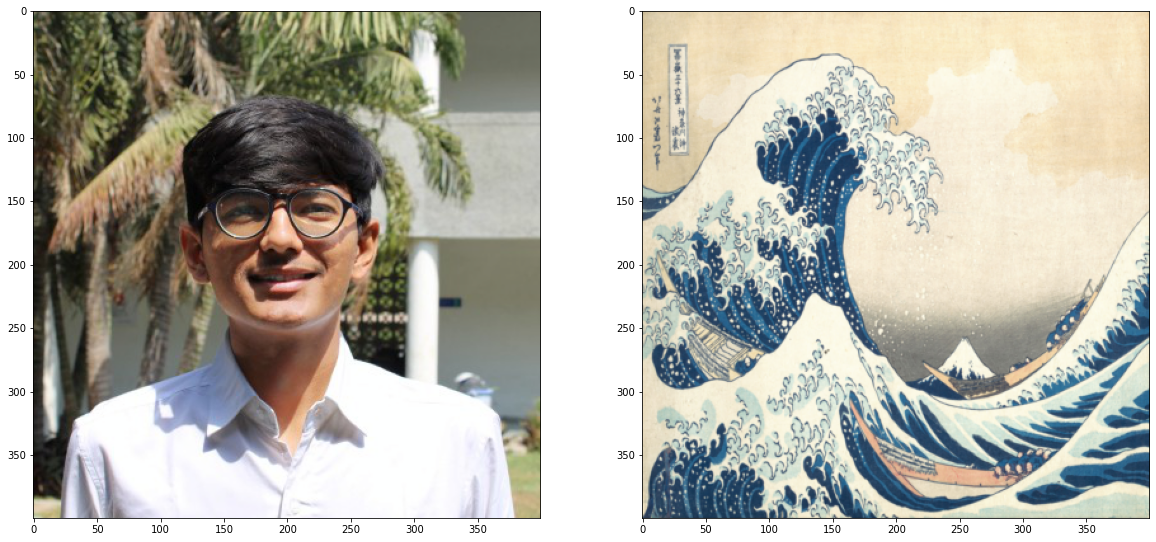

In [5]:
# tensor to numpy
def im_convert(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image
  
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))


### Content and Style Features


In [6]:
def extract_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### Gram Matrix

In [7]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())    
    return gram 

In [8]:
# get content and style features only once before training
content_features = extract_features(content, vgg)
style_features = extract_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

### Loss and Weights

In [9]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

### Updating the target and calculating Losses

Total loss:  14818785.0


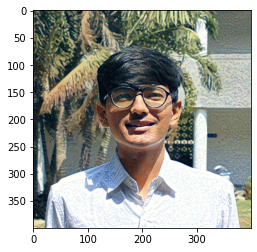

Total loss:  8176302.0


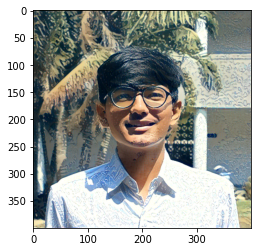

Total loss:  5533965.5


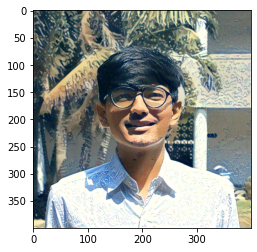

Total loss:  4044796.5


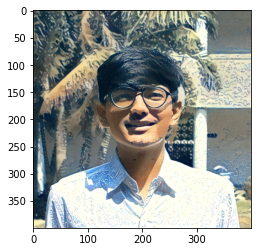

Total loss:  3120635.0


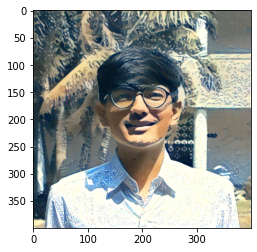

Total loss:  2505964.75


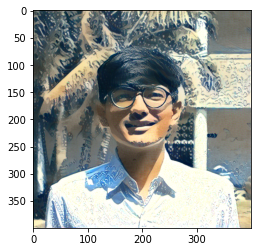

Total loss:  2071733.0


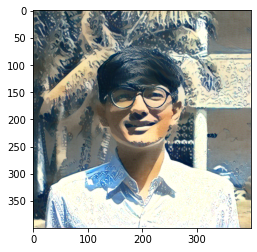

Total loss:  1747500.5


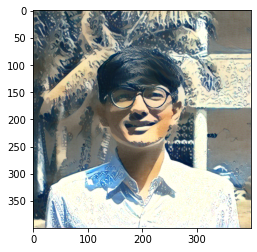

Total loss:  1494201.5


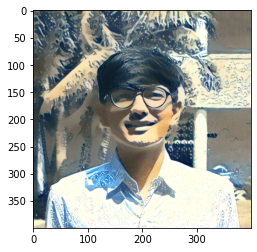

Total loss:  1290770.375


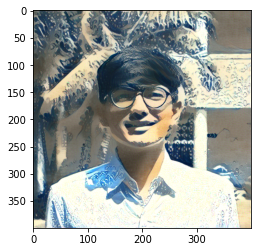

Total loss:  1122860.875


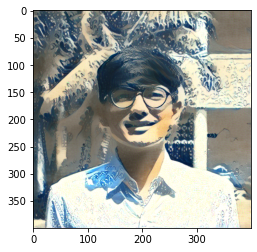

Total loss:  981583.3125


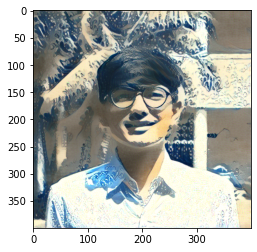

<Figure size 432x288 with 0 Axes>

In [10]:
display_after = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  

for ii in range(1, steps+1):
    # content loss
    target_features = extract_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  

    # style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
      

    # calculate total loss
    total_loss = content_weight * content_loss + style_weight * style_loss


    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    

    # display intermediate images and print the loss
    if  ii % display_after == 0:
        tloss=total_loss.item()
        print('Total loss: ', tloss)
        plt.imshow(im_convert(target))
        plt.show()
        plt.savefig("res_"+str(ii)+"_err_"+str(tloss)+".jpg")
        # files.download("res_"+str(ii)+"_err_"+str(tloss)+".jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

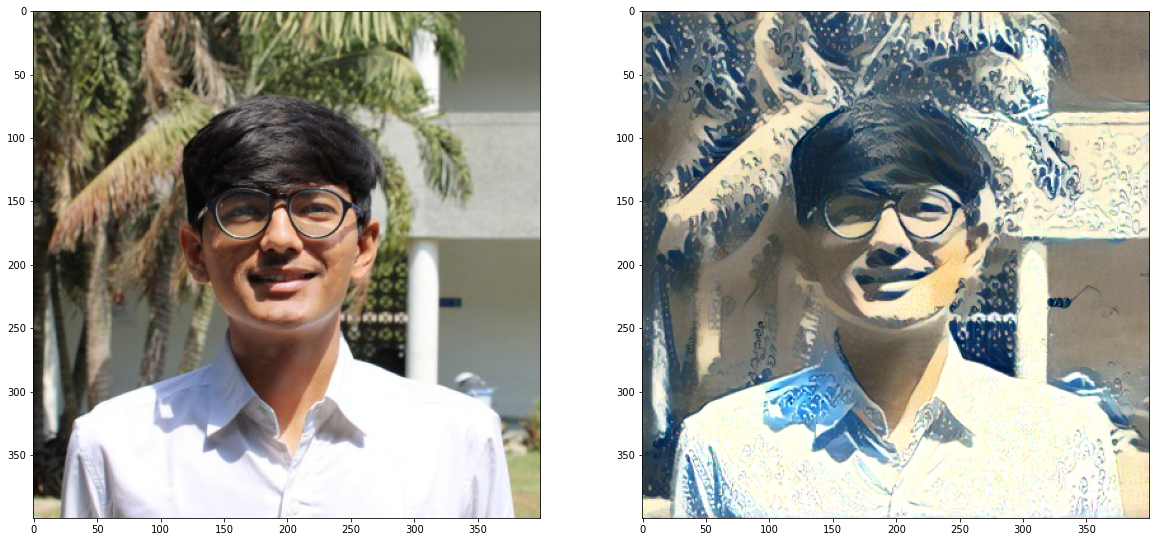

In [14]:
# display content and final, target image
from google.colab import files
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
plt.savefig('abc.pdf')
files.download( "abc.pdf" )

In [22]:
files.download("test.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
!ls

sample_data
